## This notebook will construct the nodes and edges that we will build our graph with

In this notebook we use peaks that have been extracted from the spectra to construct a graph. Each node in the graph will be a peak, with attributes such as width of that peak, its Status, etc. . Edges between two peaks will exist based on two conditions. The first condition is that every peak, within a sample, will be connected to each other. The second condition is based on matching grid-slots. This means we will parse our spectra into grid squares and if two peaks are present in the same grid square, a relationjship will exist between them.

These relationships will be weighted by distance. That means we treat each peak as a point in a co-ordinate plane and calculate the euclidean distance between them. As the peaks in the same grid-slots will inherently be closer to each other than the peaks in the same sample, we will separately minmax scale these distances, so as not to give prefernece to one type of relationship. As well as this, in a graph, a larger weight is meant to represent a stronger connection between nodes. In order to account for this, we will get the inverse of our scaled distance to used as the relationship weight as we want peaks that are closer together to have a stronger connection.

Import relevant libraries and import raw data

In [1]:
import seaborn as sns
import pandas as pd
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
os_name = os.name

if os_name == 'nt':
    password = os.getenv('NEO4J_Password')
    neo4j_directory = os.getenv('NEO4J_Directory')
else:
    password = os.environ['NEO4J_Password']
    neo4j_directory = os.environ['NEO4J_Directory']

In [3]:
#df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")

In [11]:
#df = pd.read_csv("../../data/current_clean_spectrum.csv")
df = pd.read_csv("../../data/kfold_parameters.csv")

In [12]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
0,201210-1-00,293,400.22778,201210-1,Normal,0.024722
1,201210-1-00,294,400.91116,201210-1,Normal,0.024731
2,201210-1-00,295,401.59454,201210-1,Normal,0.024737
3,201210-1-00,296,402.27789,201210-1,Normal,0.024741
4,201210-1-00,297,402.96127,201210-1,Normal,0.024743
...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,0.016583
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,0.016581
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,0.016580
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,0.016580


Here we use scipy's function "find_peaks" to find all peaks in each individual spectra sample as well as pulling featurse such as prominence and width of peaks

In [26]:
peaks = []
widths = []
prom = []

for _, group in df.groupby('SpecID'):
    peak_index, weights = find_peaks(x=group['Absorbance'], prominence=0.0005, width=6)
    peaks += list(group.iloc[peak_index].index.values)
    widths += list(weights['widths'])
    prom += list(weights['prominences'])

In [27]:
print(len(peaks))

39273


Below shows a scatterplot of the coordinates of all the peaks we have found

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

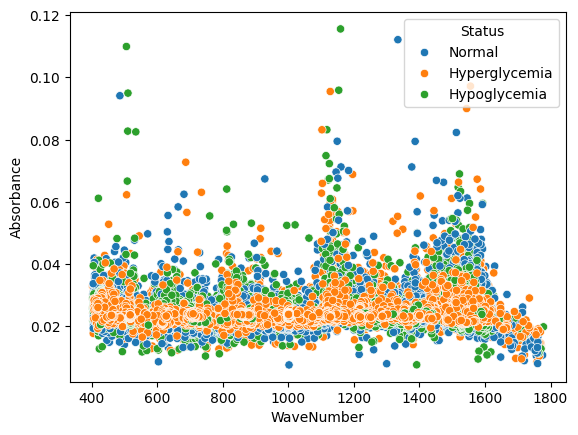

In [28]:
sns.scatterplot(data=df.iloc[peaks].reset_index(), x="WaveNumber", y="Absorbance", hue="Status")

We then add the peak information to our main dataframe

In [29]:
peak_df = df.iloc[peaks]
peak_df['Widths'] = widths
peak_df['Prominences'] = prom

/tmp/ipykernel_6311/2901317241.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['Widths'] = widths
/tmp/ipykernel_6311/2901317241.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['Prominences'] = prom


We then use the function to assign each peak we have found to a grid slot. We have speicified the slot sizes as they give a meaningful overlap to build our graph

In [30]:
def assign_to_grid(x, y, x_slot_size, y_slot_size):

    x_index = int(x / x_slot_size)
    y_index = int(y / y_slot_size)

    return x_index, y_index

In [37]:
# Set the size of the grid slots
WaveNumber_slot_size = 50
Absorbance_slot_size = 0.0005

peak_df['GridSlot'] = peak_df.apply(lambda row: assign_to_grid(row['WaveNumber'], row['Absorbance'], WaveNumber_slot_size, Absorbance_slot_size), axis=1)

/tmp/ipykernel_6311/4138372976.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['GridSlot'] = peak_df.apply(lambda row: assign_to_grid(row['WaveNumber'], row['Absorbance'], WaveNumber_slot_size, Absorbance_slot_size), axis=1)


In [38]:
peak_df['GridSlot'].nunique()

1449

In [39]:
peak_df.head()

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance,Widths,Prominences,GridSlot
316,201210-1-00,609,616.17310,201210-1,Normal,0.025505,54.113672,0.001792,"(12, 51)"
431,201210-1-00,724,694.76080,201210-1,Normal,0.025636,40.603053,0.002124,"(13, 51)"
731,201210-1-00,1024,899.77222,201210-1,Normal,0.024130,110.869465,0.001405,"(17, 48)"
883,201210-1-00,1176,1003.64470,201210-1,Normal,0.023691,38.784962,0.001060,"(20, 47)"
1233,201210-1-00,1526,1242.82460,201210-1,Normal,0.021797,32.868923,0.000532,"(24, 43)"


We will use "Node_ID" to find distances between peaks later on for our edge construction

In [40]:
peak_df['Node_ID'] = peak_df.index

/tmp/ipykernel_6311/412265839.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peak_df['Node_ID'] = peak_df.index


In [41]:
peak_df = peak_df.drop(columns=['Seq', 'SurID'])

Here we join the peak dataframe with itself in order to match peaks within the same Spectra Sample

In [42]:
same_sample = pd.merge(peak_df, peak_df[['SpecID', 'Node_ID']], on='SpecID', how='outer', suffixes=('_src', '_dst'))
same_sample['LINK:TYPE'] = 'SAMPLE'

In [43]:
same_sample.head()

,SpecID,WaveNumber,Status,Absorbance,Widths,Prominences,GridSlot,Node_ID_src,Node_ID_dst,LINK:TYPE
0,201210-1-00,616.1731,Normal,0.025505,54.113672,0.001792,"(12, 51)",316,316,SAMPLE
1,201210-1-00,616.1731,Normal,0.025505,54.113672,0.001792,"(12, 51)",316,431,SAMPLE
2,201210-1-00,616.1731,Normal,0.025505,54.113672,0.001792,"(12, 51)",316,731,SAMPLE
3,201210-1-00,616.1731,Normal,0.025505,54.113672,0.001792,"(12, 51)",316,883,SAMPLE
4,201210-1-00,616.1731,Normal,0.025505,54.113672,0.001792,"(12, 51)",316,1233,SAMPLE


We then join the dataframe with itself again, this time to match peaks in the same grid slot

In [44]:
same_grid_slot = pd.merge(peak_df, peak_df[['GridSlot', 'Node_ID']], on='GridSlot', how='outer', suffixes=('_src', '_dst'))
same_grid_slot['LINK:TYPE'] = 'GRID'

In [45]:
same_grid_slot.head()

,SpecID,WaveNumber,Status,Absorbance,Widths,Prominences,GridSlot,Node_ID_src,Node_ID_dst,LINK:TYPE
0,201210-1-00,616.1731,Normal,0.025505,54.113672,0.001792,"(12, 51)",316,316,GRID
1,201210-1-00,616.1731,Normal,0.025505,54.113672,0.001792,"(12, 51)",316,49483,GRID
2,201210-1-00,616.1731,Normal,0.025505,54.113672,0.001792,"(12, 51)",316,55635,GRID
3,201210-1-00,616.1731,Normal,0.025505,54.113672,0.001792,"(12, 51)",316,59744,GRID
4,201210-1-00,616.1731,Normal,0.025505,54.113672,0.001792,"(12, 51)",316,61764,GRID


We the combine these new dataframes together to form our relationship dataframe and we perform some clean to get rid of columns we don't need and renaming columns to get them ready for neo4j

In [46]:
graph_df = pd.concat([same_sample, same_grid_slot], ignore_index=True)

In [47]:
del same_sample
del same_grid_slot

In [48]:
graph_df = graph_df.drop(columns=['SpecID', 'GridSlot', 'WaveNumber', 'Absorbance', 'Status', 'Widths', 'Prominences'])

In [49]:
graph_df = graph_df.rename(columns={'Node_ID_src':':START_ID', 'Node_ID_dst':':END_ID'})

In [50]:
graph_df

,:START_ID,:END_ID,LINK:TYPE
0,316,316,SAMPLE
1,316,431,SAMPLE
2,316,731,SAMPLE
3,316,883,SAMPLE
4,316,1233,SAMPLE
...,...,...,...
5935605,6093529,6095564,GRID
5935606,6095564,6077119,GRID
5935607,6095564,6089428,GRID
5935608,6095564,6093529,GRID


This gets rid of relationships that match nodes to themselves

In [51]:
graph_df = graph_df[graph_df[':START_ID'] != graph_df[':END_ID']]

We make use of built in numpy functions to efficiently calculate distances between all of our relationships

In [52]:
wave = peak_df['WaveNumber']
absorb = peak_df['Absorbance']

src_indices = graph_df[':START_ID'].values
dst_indices = graph_df[':END_ID'].values

src_coords = np.column_stack((wave[src_indices], absorb[src_indices]))
dst_coords = np.column_stack((wave[dst_indices], absorb[dst_indices]))

distances = np.linalg.norm(src_coords - dst_coords, axis=1)

dist = distances.tolist()

In [53]:
graph_df['DIST'] = dist

/tmp/ipykernel_6311/3060805488.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph_df['DIST'] = dist


In [54]:
graph_df.head()

,:START_ID,:END_ID,LINK:TYPE,DIST
1,316,431,SAMPLE,78.58770
2,316,731,SAMPLE,283.59912
3,316,883,SAMPLE,387.47160
4,316,1233,SAMPLE,626.65150
5,431,316,SAMPLE,78.58770


In [55]:
from sklearn.preprocessing import MinMaxScaler

sample_data = graph_df[graph_df['LINK:TYPE'] == 'SAMPLE']
grid_data = graph_df[graph_df['LINK:TYPE'] == 'GRID']

scaler = MinMaxScaler()

sample_data['DIST'] = 1 - scaler.fit_transform(sample_data[['DIST']])
grid_data['DIST'] = 1 -scaler.fit_transform(grid_data[['DIST']])

scaled_df = pd.concat([sample_data, grid_data])

/tmp/ipykernel_6311/945116818.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_data['DIST'] = 1 - scaler.fit_transform(sample_data[['DIST']])
/tmp/ipykernel_6311/945116818.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grid_data['DIST'] = 1 -scaler.fit_transform(grid_data[['DIST']])


In [56]:
scaled_df.rename(columns={'DIST':'DIST:float'}, inplace=True)

In [57]:
scaled_df.head()

,:START_ID,:END_ID,LINK:TYPE,DIST:float
1,316,431,SAMPLE,0.952935
2,316,731,SAMPLE,0.801113
3,316,883,SAMPLE,0.724190
4,316,1233,SAMPLE,0.547065
5,431,316,SAMPLE,0.952935


In [58]:
scaled_df.to_csv(f"{neo4j_directory}/import/relationships.csv", index=False)

Finally, we clean and rename columsn in our main node dataframe to get it ready for neo4j

In [59]:
peak_df

,SpecID,WaveNumber,Status,Absorbance,Widths,Prominences,GridSlot,Node_ID
316,201210-1-00,616.17310,Normal,0.025505,54.113672,0.001792,"(12, 51)",316
431,201210-1-00,694.76080,Normal,0.025636,40.603053,0.002124,"(13, 51)",431
731,201210-1-00,899.77222,Normal,0.024130,110.869465,0.001405,"(17, 48)",731
883,201210-1-00,1003.64470,Normal,0.023691,38.784962,0.001060,"(20, 47)",883
1233,201210-1-00,1242.82460,Normal,0.021797,32.868923,0.000532,"(24, 43)",1233
...,...,...,...,...,...,...,...,...
6227364,210526-3-49,709.79498,Hyperglycemia,0.024053,127.476803,0.001375,"(14, 48)",6227364
6227561,210526-3-49,844.41913,Hyperglycemia,0.023785,100.718051,0.000774,"(16, 47)",6227561
6227790,210526-3-49,1000.91110,Hyperglycemia,0.023861,33.681589,0.001028,"(20, 47)",6227790
6227976,210526-3-49,1128.01820,Hyperglycemia,0.023011,61.944315,0.000503,"(22, 46)",6227976


In [60]:
peak_df.rename(columns={"Status":"Status:LABEL"}, inplace=True)

In [61]:
peak_df.rename(columns={'WaveNumber':'WaveNumber:float', 'Absorbance':'Absorbance:float', 'Widths':'Widths:float', 'Prominences':'Prominences:float', 'Node_ID':'Node_ID:ID'}, inplace=True)

In [62]:
peak_df.to_csv(f'{neo4j_directory}/import/nodes.csv', index=False)

#### Creating Graph and Running Queries in Neo4j

In [63]:
from neo4j import GraphDatabase
import os
import pandas as pd
import shutil
import subprocess

In [64]:
del graph_df
del scaled_df
del peak_df
del df

In [65]:
del dist

This moves the nodes and relationships files from data/current_working_graph into the DBMS import folder.

At the moment this uses local paths, but the rest should be automated.

Then run the admin import command.

In [66]:
os_name = os.name

if os_name == 'nt':
    working_dir = f'{neo4j_directory}/bin'
    command = 'neo4j-admin database import full --nodes=import/nodes.csv --relationships=import/relationships.csv --overwrite-destination neo4j'
    result = subprocess.run(command, shell=True, cwd=working_dir, capture_output=True, text=True)
else:
    working_dir = f'{neo4j_directory}'
    command = [
    './bin/neo4j-admin', 'database', 'import', 'full',
    '--nodes=import/nodes.csv',
    '--relationships=import/relationships.csv',
    '--overwrite-destination',  'neo4j'
    ]
    result = subprocess.run(command, cwd=working_dir, stdout=subprocess.PIPE, stderr=subprocess.PIPE)


# Check if the command was successful
if result.returncode == 0:
    print("Import successful")
    print(result.stdout)
else:
    print("Error during import:")
    print(result.stderr)

Import successful
b"Neo4j version: 5.12.0\nImporting the contents of these files into /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/data/databases/neo4j:\nNodes:\n  /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/import/nodes.csv\n\nRelationships:\n  /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/import/relationships.csv\n\n\nAvailable resources:\n  Total machine memory: 15.47GiB\n  Free machine memory: 6.780GiB\n  Max heap memory : 910.5MiB\n  Max worker threads: 8\n  Configured max memory: 4.718GiB\n  High parallel IO: true\n\nCypher type normalization is enabled (disable with --normalize-types=false):\n  Property type of 'WaveNumber' normalized from 'float' --> 'double' in /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/import/nodes.csv\n  Property typ

In [67]:
if os_name != 'nt':
    command = [
        './bin/neo4j', 'restart'
    ]

    result = subprocess.run(command, cwd=neo4j_directory, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    # Check if the command was successful
    if result.returncode == 0:
        print("Restart successful")
        print(result.stdout)
    else:
        print("Error during restart:")
        print(result.stderr)

Restart successful
b'Stopping Neo4j........... stopped.\nConfiguration file validation successful (with warnings).\nDirectories in use:\nhome:         /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5\nconfig:       /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/conf\nlogs:         /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/logs\nplugins:      /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/plugins\nimport:       /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/import\ndata:         /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-9ffc2f61bbc5/data\ncertificates: /home/stang/.config/Neo4j Desktop/Application/relate-data/dbmss/dbms-f413c23c-3abd-47d4-a611-

Run and connect to the Neo4j Database

In [68]:
from neo4j import GraphDatabase

uri = "neo4j://localhost:7687"
username = "neo4j"              # Neo4J username
#Passwords is defined at the top of the notebook

# Create a driver instance
driver = GraphDatabase.driver(uri, auth=(username, password))

# Ensure you close the driver connection when your program ends
def close_driver():
    driver.close()

**First create the gds Graph Projection**

In [69]:
def project_graph(tx):
    query = """
    CALL gds.graph.project(
      'myGraph', 
      ['Normal', 'Hyperglycemia', 'Hypoglycemia'],
      {
        SAMPLE: {
          orientation: 'UNDIRECTED',
          properties: 'DIST'
        },
        GRID: {
          orientation: 'UNDIRECTED',
          properties: 'DIST'
        }
      }
    )
    """
    tx.run(query)

# Use a session to execute the graph projection
with driver.session() as session:
    session.execute_write(project_graph)

Unable to retrieve routing information
Transaction failed and will be retried in 0.9882720515441035s (Unable to retrieve routing information)
Unable to retrieve routing information
Transaction failed and will be retried in 2.2647875265897848s (Unable to retrieve routing information)
Unable to retrieve routing information
Transaction failed and will be retried in 4.5269509332869s (Unable to retrieve routing information)
Unable to retrieve routing information
Transaction failed and will be retried in 7.303885497611681s (Unable to retrieve routing information)
Unable to retrieve routing information
Transaction failed and will be retried in 15.502314995838436s (Unable to retrieve routing information)


Define the graph algorithms.

In [70]:
def run_pagerank_centrality(tx):
    query = """
    CALL gds.pageRank.stream('myGraph', {
        relationshipWeightProperty: 'DIST'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["score"]) for record in results]

In [71]:
def run_degree_centrality(tx):
    query = """
    CALL gds.degree.stream('myGraph', {
        relationshipWeightProperty: 'DIST'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["score"]) for record in results]

In [72]:
def run_eigenvector_centrality(tx):
    query = """
    CALL gds.eigenvector.stream('myGraph', {
        relationshipWeightProperty: 'DIST'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["score"]) for record in results]

In [73]:
def run_articlerank_centrality(tx):
    query = """
    CALL gds.articleRank.stream('myGraph', {
        relationshipWeightProperty: 'DIST'
    })
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, score
    ORDER BY score DESC, name ASC
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["score"]) for record in results]

In [74]:
def run_label_propagation_algorithm(tx):
    query = """
    CALL gds.labelPropagation.stream('myGraph', { relationshipWeightProperty: 'DIST' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, Community
    ORDER BY Community, name
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["Community"]) for record in results]

In [75]:
def run_leiden_algorithm(tx):
    query = """
    CALL gds.leiden.stream('myGraph', { relationshipWeightProperty: 'DIST' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, Community
    ORDER BY Community, name
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["Community"]) for record in results]

In [76]:
def run_louvain_algorithm(tx):
    query = """
    CALL gds.louvain.stream('myGraph', { relationshipWeightProperty: 'DIST' })
    YIELD nodeId, communityId AS Community
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, Community
    ORDER BY Community, name
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["Community"]) for record in results]

In [77]:
def run_node2vec_algorithm(tx):
    query = """
    CALL gds.node2vec.stream('myGraph', { relationshipWeightProperty: 'Weight' })
    YIELD nodeId, embedding
    RETURN gds.util.asNode(nodeId).SpecID AS name, embedding
    """
    results = tx.run(query)
    return [(record["name"], record["embedding"]) for record in results]

In [78]:
def run_fastRP_algorithm(tx):
    query = """
    CALL gds.fastRP.stream('myGraph',
        { relationshipWeightProperty: 'DIST',
         randomSeed:1234,
         embeddingDimension: 128
        }
    )
    YIELD nodeId, embedding
    RETURN gds.util.asNode(nodeId).SpecID AS name, gds.util.asNode(nodeId).Node_ID AS id, embedding
    """
    results = tx.run(query)
    return [(record["name"], record["id"], record["embedding"]) for record in results]

Execute the algorithms and store the results in a Dataframe.

In [79]:
# Use a session to execute the queries and retrieve the results
with driver.session() as session:
    pagerank_results = session.execute_read(run_pagerank_centrality)
    degree_results = session.execute_read(run_degree_centrality)
    eigenvector_results = session.execute_read(run_eigenvector_centrality)
    articlerank_results = session.execute_read(run_articlerank_centrality)
    label_propagation_results = session.execute_read(run_label_propagation_algorithm)
    leiden_results = session.execute_read(run_leiden_algorithm)
    louvain_results = session.execute_read(run_louvain_algorithm)

In [80]:
pagerank_df = pd.DataFrame(pagerank_results, columns=['name', 'id', 'PageRank'])
degree_df = pd.DataFrame(degree_results, columns=['name', 'id', 'DegreeCentrality'])
eigenvector_df = pd.DataFrame(eigenvector_results, columns=['name', 'id', 'EigenvectorCentrality'])
articlerank_df = pd.DataFrame(articlerank_results, columns=['name', 'id', 'ArticleRank'])
label_propagation_df = pd.DataFrame(label_propagation_results, columns=['name', 'id', 'LabelPropagation'])
leiden_df = pd.DataFrame(leiden_results, columns=['name', 'id', 'Leiden'])
louvain_df = pd.DataFrame(louvain_results, columns=['name', 'id', 'Louvain'])

In [81]:
merged_df = pagerank_df
for df in [degree_df, eigenvector_df, articlerank_df, leiden_df, louvain_df]:
    merged_df = pd.merge(merged_df, df, on=['id', 'name'], how='left')

In [82]:
df = merged_df.rename(columns={'name' : 'SpecID'})
df

,SpecID,id,PageRank,DegreeCentrality,EigenvectorCentrality,ArticleRank,Leiden,Louvain
0,210407-1-02,4018416,1.752680,438.793973,0.008978,0.309080,164,16142
1,210120-1-19,447953,1.698252,440.310053,0.008683,0.308119,297,38773
2,210120-1-26,461909,1.680232,1027.656457,0.010313,0.455448,363,30208
3,210324-1-18,2904318,1.677404,804.877927,0.009689,0.404838,77,29927
4,210519-2-05,5861019,1.655871,1025.759782,0.010388,0.455455,363,30208
...,...,...,...,...,...,...,...,...
39268,210519-2-46,5853928,0.201995,12.539472,0.000279,0.154710,271,17323
39269,210519-3-49,5962428,0.198309,10.371457,0.000253,0.154007,336,20629
39270,210114-2-48,405503,0.196119,8.704424,0.000207,0.153372,295,11668
39271,210519-3-47,5958369,0.192572,9.806679,0.000236,0.153739,157,2442


In [83]:
with driver.session() as session:
    fastRP_results = session.execute_read(run_fastRP_algorithm)

fastRP_df = pd.DataFrame(fastRP_results, columns=['SpecID', 'id', 'embeddings'])

# Expand the embeddings list into separate columns
embeddings_df = pd.DataFrame(fastRP_df['embeddings'].tolist(), index=fastRP_df.index)

# Optionally, rename the new columns
embeddings_df.columns = [f'embedding_{i}' for i in range(embeddings_df.shape[1])]

# Join the new embeddings columns to the original DataFrame
fastRP_df = pd.concat([fastRP_df.drop(['embeddings'], axis=1), embeddings_df], axis=1)
fastRP_df.to_csv('../../data/fastRP_embeddings.csv', index=False)
fastRP_df.head()

,SpecID,id,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,...,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127
0,210519-3-04,5940975,-0.039459,0.207652,-0.001197,-0.191840,0.308392,0.052950,-0.091534,0.006057,...,-0.040576,-0.081428,-0.232967,0.305202,-0.193349,0.277322,-0.125808,-0.262463,-0.062080,0.176374
1,210519-3-04,5941114,-0.263147,0.198992,0.188867,0.153430,-0.225134,-0.246389,0.200347,-0.133717,...,0.334067,-0.095552,-0.068221,-0.310498,0.244267,0.016887,0.105123,0.033169,0.078648,-0.402960
2,210519-3-04,5941158,-0.152995,-0.072466,0.096654,-0.054905,0.074913,0.043847,-0.110797,-0.083947,...,0.039450,0.000590,0.003799,-0.443266,-0.183857,0.244229,0.146025,-0.131214,-0.009812,-0.241582
3,210519-3-04,5941231,0.282438,0.080861,0.015864,0.218288,0.362186,0.015152,-0.163232,-0.207496,...,0.103756,0.077488,-0.029881,0.246112,0.037500,0.050009,-0.180388,-0.231656,-0.117303,0.066002
4,210519-3-04,5941355,0.049024,0.021492,0.168377,0.033763,0.315308,0.066801,0.110761,-0.021253,...,0.045286,-0.016203,0.101442,0.110139,0.177042,-0.012469,0.198983,-0.105502,-0.152084,0.206582


In [84]:
status_df = pd.read_csv(f'{neo4j_directory}/import/nodes.csv')

In [85]:
fastRP_df['id'] = fastRP_df['id'].astype(int)

In [86]:
df['id'] = df['id'].astype(int)

In [87]:
graph_df = pd.merge(df, status_df, left_on="id", right_on="Node_ID:ID", how="inner")
graph_df.drop(columns=["Node_ID:ID"], inplace=True)

In [88]:
fast_graph_df = pd.merge(fastRP_df, status_df, left_on="id", right_on="Node_ID:ID", how="inner")
fast_graph_df.drop(columns=["Node_ID:ID"], inplace=True)

In [89]:
graph_df.rename(columns={"Status:LABEL":"Status"}, inplace=True)
graph_df.drop(columns=['SpecID_y','Absorbance:float', 'Widths:float', 'Prominences:float', 'GridSlot'], inplace=True)
graph_df.rename(columns={'SpecID_x':'SpecID'}, inplace=True)

In [90]:
fast_graph_df.rename(columns={"Status:LABEL":"Status"}, inplace=True)

In [91]:
fast_graph_df.drop(columns=['SpecID_y', 'WaveNumber:float', 'Absorbance:float', 'Widths:float', 'Prominences:float', 'GridSlot'], inplace=True)
fast_graph_df.rename(columns={'SpecID_x':'SpecID'}, inplace=True)

In [92]:
graph_df

,SpecID,id,PageRank,DegreeCentrality,EigenvectorCentrality,ArticleRank,Leiden,Louvain,WaveNumber:float,Status
0,210407-1-02,4018416,1.752680,438.793973,0.008978,0.309080,164,16142,623.69019,Hypoglycemia
1,210120-1-19,447953,1.698252,440.310053,0.008683,0.308119,297,38773,1268.79270,Hyperglycemia
2,210120-1-26,461909,1.680232,1027.656457,0.010313,0.455448,363,30208,1004.32800,Hyperglycemia
3,210324-1-18,2904318,1.677404,804.877927,0.009689,0.404838,77,29927,1005.01140,Normal
4,210519-2-05,5861019,1.655871,1025.759782,0.010388,0.455455,363,30208,1000.91110,Hyperglycemia
...,...,...,...,...,...,...,...,...,...,...
39268,210519-2-46,5853928,0.201995,12.539472,0.000279,0.154710,271,17323,1756.03650,Hyperglycemia
39269,210519-3-49,5962428,0.198309,10.371457,0.000253,0.154007,336,20629,1689.74940,Hyperglycemia
39270,210114-2-48,405503,0.196119,8.704424,0.000207,0.153372,295,11668,1664.46470,Normal
39271,210519-3-47,5958369,0.192572,9.806679,0.000236,0.153739,157,2442,1716.40090,Hyperglycemia


In [93]:
# Define a function to calculate the bin for a given wavenumber with a specified bin size
def calculate_bin_interval(wavenumber, bin_size):
    bin_start = int((wavenumber - 200) / bin_size) * bin_size + 200
    bin_end = bin_start + bin_size
    return f"{bin_start}-{bin_end}"

# Set the bin size
bin_size = 25

# Add a "Bin" column to the DataFrame
graph_df['Bin'] = graph_df['WaveNumber:float'].apply(lambda x: calculate_bin_interval(x, bin_size))

In [94]:
# Pivot table with 'Absorbance', 'PeakWidths', and 'PeakProminences' as values
peak_bins = graph_df.pivot_table(index='SpecID', columns='Bin', values=['PageRank', 'DegreeCentrality', 'EigenvectorCentrality', 'ArticleRank', 'Leiden', 'Louvain'], aggfunc='mean')
peak_bins.columns = [f"{col[0]}_{col[1]}" for col in peak_bins.columns]  # Combine column names
peak_bins.reset_index(inplace=True)

# Merge with 'Status' information
statuses = graph_df[['SpecID', 'Status']].drop_duplicates()
peak_bins = pd.merge(peak_bins, statuses, on='SpecID')

# Set 'SpecID' as the index
peak_bins.set_index('SpecID', inplace=True)

# Fill NaN values with False
peak_bins.fillna(False, inplace=True)

/tmp/ipykernel_6311/286844324.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  peak_bins.fillna(False, inplace=True)


In [95]:
graph_bins = peak_bins.reset_index()

In [96]:
peak_bins

,ArticleRank_1000-1025,ArticleRank_1025-1050,ArticleRank_1050-1075,ArticleRank_1075-1100,ArticleRank_1100-1125,ArticleRank_1125-1150,ArticleRank_1150-1175,ArticleRank_1175-1200,ArticleRank_1200-1225,ArticleRank_1225-1250,...,PageRank_775-800,PageRank_800-825,PageRank_825-850,PageRank_850-875,PageRank_875-900,PageRank_900-925,PageRank_925-950,PageRank_950-975,PageRank_975-1000,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,0.397964,False,False,False,False,False,False,False,False,0.198577,...,False,False,False,False,0.626664,False,False,False,False,Normal
201210-1-01,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,0.406838,False,False,1.141045,Normal
201210-1-02,False,0.291041,False,False,False,0.254693,False,False,False,False,...,False,False,False,False,False,0.210449,False,False,False,Normal
201210-1-03,False,False,False,False,False,False,0.177914,False,False,False,...,False,False,False,False,False,0.332245,False,0.80991,False,Normal
201210-1-04,0.258685,False,False,False,False,False,False,0.246096,False,False,...,False,False,False,False,False,False,False,False,False,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210526-3-45,0.393255,False,False,False,False,False,False,False,False,False,...,False,False,False,1.222713,False,False,False,False,False,Hyperglycemia
210526-3-46,0.398265,False,False,False,False,False,False,False,False,False,...,False,False,False,1.234091,False,False,False,False,False,Hyperglycemia
210526-3-47,0.399199,False,False,False,0.268188,False,False,False,False,False,...,False,False,False,False,1.169759,False,False,False,False,Hyperglycemia


In [98]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold
import numpy as np

# Splitting the dataframe into features (X) and target variable (y)
X = peak_bins.drop(['Status'], axis=1)
y = peak_bins['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)
svc = SVC(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et, svc]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = KFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_validate(clf, X, y, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], n_jobs=-1)
    
    # Displaying the results
    print(f"{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores['test_accuracy']):.4f} +/- {np.std(scores['test_accuracy']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation Precision: {np.mean(scores['test_precision_macro']):.4f} +/- {np.std(scores['test_precision_macro']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation Recall: {np.mean(scores['test_recall_macro']):.4f} +/- {np.std(scores['test_recall_macro']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation F1-Score: {np.mean(scores['test_f1_macro']):.4f} +/- {np.std(scores['test_f1_macro']):.4f}")

RandomForestClassifier Cross-Validation Accuracy: 0.7109 +/- 0.0171
RandomForestClassifier Cross-Validation Precision: 0.7123 +/- 0.0162
RandomForestClassifier Cross-Validation Recall: 0.7114 +/- 0.0163
RandomForestClassifier Cross-Validation F1-Score: 0.7089 +/- 0.0160
ExtraTreesClassifier Cross-Validation Accuracy: 0.7277 +/- 0.0206
ExtraTreesClassifier Cross-Validation Precision: 0.7293 +/- 0.0190
ExtraTreesClassifier Cross-Validation Recall: 0.7275 +/- 0.0200
ExtraTreesClassifier Cross-Validation F1-Score: 0.7258 +/- 0.0203
SVC Cross-Validation Accuracy: 0.5979 +/- 0.0342
SVC Cross-Validation Precision: 0.5978 +/- 0.0358
SVC Cross-Validation Recall: 0.5941 +/- 0.0344
SVC Cross-Validation F1-Score: 0.5925 +/- 0.0345


Original:
RandomForestClassifier Cross-Validation Accuracy: 0.7630 +/- 0.0171
ExtraTreesClassifier Cross-Validation Accuracy: 0.7654 +/- 0.0185

In [105]:
def evaluate_model(df, model):

    # Set the Surfaces as groups
    X = df.drop(['Status'], axis=1)
    y = df['Status']
    
    # Using GroupKFold for classification tasks
    cv = KFold(n_splits=10, shuffle=True, random_state=1234)

    # Cross Validate
    scores = cross_validate(model, X, y, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], n_jobs=-1)

    # Displaying the results
    print(f"{model.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores['test_accuracy']):.4f} +/- {np.std(scores['test_accuracy']):.4f}")
    print(f"{model.__class__.__name__} Cross-Validation Precision: {np.mean(scores['test_precision_macro']):.4f} +/- {np.std(scores['test_precision_macro']):.4f}")
    print(f"{model.__class__.__name__} Cross-Validation Recall: {np.mean(scores['test_recall_macro']):.4f} +/- {np.std(scores['test_recall_macro']):.4f}")
    print(f"{model.__class__.__name__} Cross-Validation F1-Score: {np.mean(scores['test_f1_macro']):.4f} +/- {np.std(scores['test_f1_macro']):.4f}")

In [107]:
for clf in classifiers:
    evaluate_model(peak_bins, clf)

RandomForestClassifier Cross-Validation Accuracy: 0.7109 +/- 0.0171
RandomForestClassifier Cross-Validation Precision: 0.7123 +/- 0.0162
RandomForestClassifier Cross-Validation Recall: 0.7114 +/- 0.0163
RandomForestClassifier Cross-Validation F1-Score: 0.7089 +/- 0.0160
ExtraTreesClassifier Cross-Validation Accuracy: 0.7277 +/- 0.0206
ExtraTreesClassifier Cross-Validation Precision: 0.7293 +/- 0.0190
ExtraTreesClassifier Cross-Validation Recall: 0.7275 +/- 0.0200
ExtraTreesClassifier Cross-Validation F1-Score: 0.7258 +/- 0.0203
SVC Cross-Validation Accuracy: 0.5979 +/- 0.0342
SVC Cross-Validation Precision: 0.5978 +/- 0.0358
SVC Cross-Validation Recall: 0.5941 +/- 0.0344
SVC Cross-Validation F1-Score: 0.5925 +/- 0.0345


In [108]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=1234)
rf_model.fit(X_train, y_train)

# Extra Trees model
et_model = ExtraTreesClassifier(n_estimators=100, random_state=1234)
et_model.fit(X_train, y_train)

# Predictions
rf_predictions = rf_model.predict(X_test)
et_predictions = et_model.predict(X_test)

# Evaluate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)
et_accuracy = accuracy_score(y_test, et_predictions)

In [109]:
def calculate_metrics(y_test, y_pred):

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(y_test, y_pred)
    print(f"Overall Accuracy: {overall_accuracy}\n")

    # Calculate precision, recall, and F1-score for each class
    report = classification_report(y_test, y_pred)
    print("\nClassification Report:")
    print(report)

    # Show the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(conf_matrix)

In [110]:
def get_feature_importances(model, X):

    # Get feature importances
    feature_importances = model.feature_importances_

    # Creating a DataFrame to display feature importances
    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

    # Sorting the DataFrame by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Show the top 10 most important features
    top_10_features = feature_importance_df.head(10)

    return top_10_features

In [111]:
calculate_metrics(y_test, rf_predictions)

Overall Accuracy: 0.7372742200328407


Classification Report:
               precision    recall  f1-score   support

Hyperglycemia       0.77      0.68      0.72       191
 Hypoglycemia       0.81      0.72      0.76       202
       Normal       0.67      0.81      0.73       216

     accuracy                           0.74       609
    macro avg       0.75      0.73      0.74       609
 weighted avg       0.75      0.74      0.74       609


Confusion Matrix:
[[129  13  49]
 [ 20 145  37]
 [ 19  22 175]]


In [112]:
calculate_metrics(y_test, et_predictions)

Overall Accuracy: 0.7257799671592775


Classification Report:
               precision    recall  f1-score   support

Hyperglycemia       0.72      0.69      0.70       191
 Hypoglycemia       0.76      0.71      0.74       202
       Normal       0.70      0.77      0.74       216

     accuracy                           0.73       609
    macro avg       0.73      0.72      0.72       609
 weighted avg       0.73      0.73      0.73       609


Confusion Matrix:
[[131  21  39]
 [ 26 144  32]
 [ 25  24 167]]


In [113]:
get_feature_importances(rf_model, X)

,Feature,Importance
0,ArticleRank_1000-1025,0.015952
56,DegreeCentrality_1000-1025,0.015481
168,Leiden_1000-1025,0.014571
112,EigenvectorCentrality_1000-1025,0.013841
280,PageRank_1000-1025,0.012712
224,Louvain_1000-1025,0.009880
17,ArticleRank_1425-1450,0.009107
324,PageRank_700-725,0.009089
77,DegreeCentrality_1525-1550,0.008812
156,EigenvectorCentrality_700-725,0.008746


In [114]:
get_feature_importances(et_model, X)

,Feature,Importance
168,Leiden_1000-1025,0.013668
56,DegreeCentrality_1000-1025,0.010437
0,ArticleRank_1000-1025,0.009070
112,EigenvectorCentrality_1000-1025,0.008319
218,Leiden_850-875,0.008153
224,Louvain_1000-1025,0.007944
100,DegreeCentrality_700-725,0.007643
330,PageRank_850-875,0.007631
50,ArticleRank_850-875,0.007616
156,EigenvectorCentrality_700-725,0.007544


## FastRp

In [115]:
fast_graph_df.drop(columns=['id'], inplace=True)
fast_graph_df = fast_graph_df.groupby(['SpecID', 'Status']).max().reset_index()

In [117]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming graph_df is your DataFrame

# Drop the SpecID column
X = fast_graph_df.drop(columns=['SpecID', 'Status'])

# Target variable
y = fast_graph_df['Status']

# Creating the classifiers
rf = RandomForestClassifier(random_state=1234)
et = ExtraTreesClassifier(random_state=1234)
svc = SVC(random_state=1234)

# Combining the classifiers into a list
classifiers = [rf, et, svc]

# Performing 10-fold cross-validation for each classifier
for clf in classifiers:
    
    # Using StratifiedKFold for classification tasks
    cv = KFold(n_splits=10, shuffle=True, random_state=1234)
    
    # Getting cross-validation scores
    scores = cross_validate(clf, X, y, cv=cv, scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'], n_jobs=-1)
    
    # Displaying the results
    print(f"{clf.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores['test_accuracy']):.4f} +/- {np.std(scores['test_accuracy']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation Precision: {np.mean(scores['test_precision_macro']):.4f} +/- {np.std(scores['test_precision_macro']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation Recall: {np.mean(scores['test_recall_macro']):.4f} +/- {np.std(scores['test_recall_macro']):.4f}")
    print(f"{clf.__class__.__name__} Cross-Validation F1-Score: {np.mean(scores['test_f1_macro']):.4f} +/- {np.std(scores['test_f1_macro']):.4f}")

RandomForestClassifier Cross-Validation Accuracy: 0.6130 +/- 0.0195
RandomForestClassifier Cross-Validation Precision: 0.6226 +/- 0.0178
RandomForestClassifier Cross-Validation Recall: 0.6130 +/- 0.0195
RandomForestClassifier Cross-Validation F1-Score: 0.6121 +/- 0.0195
ExtraTreesClassifier Cross-Validation Accuracy: 0.6058 +/- 0.0227
ExtraTreesClassifier Cross-Validation Precision: 0.6152 +/- 0.0235
ExtraTreesClassifier Cross-Validation Recall: 0.6058 +/- 0.0218
ExtraTreesClassifier Cross-Validation F1-Score: 0.6052 +/- 0.0219
SVC Cross-Validation Accuracy: 0.5874 +/- 0.0182
SVC Cross-Validation Precision: 0.5932 +/- 0.0164
SVC Cross-Validation Recall: 0.5867 +/- 0.0176
SVC Cross-Validation F1-Score: 0.5865 +/- 0.0168


In [118]:
for clf in classifiers:
    evaluate_model(fast_graph_df, clf)

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/home/stang/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stang/.local/lib/python3.10/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/stang/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 363, in fit
    X, y = self._validate_data(
  File "/home/stang/.local/lib/python3.10/site-packages/sklearn/base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/home/stang/.local/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1263, in check_X_y
    X = check_array(
  File "/home/stang/.local/lib/python3.10/site-packages/sklearn/utils/validation.py", line 997, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/home/stang/.local/lib/python3.10/site-packages/sklearn/utils/_array_api.py", line 521, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "/home/stang/.local/lib/python3.10/site-packages/pandas/core/generic.py", line 2084, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: '201210-1-00'

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/stang/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/stang/.local/lib/python3.10/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/stang/.local/lib/python3.10/site-packages/sklearn/ensemble/_forest.py", line 363, in fit
    X, y = self._validate_data(
  File "/home/stang/.local/lib/python3.10/site-packages/sklearn/base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/home/stang/.local/lib/python3.10/site-packages/sklearn/utils/validation.py", line 1263, in check_X_y
    X = check_array(
  File "/home/stang/.local/lib/python3.10/site-packages/sklearn/utils/validation.py", line 997, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/home/stang/.local/lib/python3.10/site-packages/sklearn/utils/_array_api.py", line 521, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "/home/stang/.local/lib/python3.10/site-packages/pandas/core/generic.py", line 2084, in __array__
    arr = np.asarray(values, dtype=dtype)
ValueError: could not convert string to float: '201210-1-01'


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming graph_df is your DataFrame

# Drop the SpecID column
X = fast_graph_df.drop(columns=['SpecID', 'Status'])

# Target variable
y = fast_graph_df['Status']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=1234)
rf_model.fit(X_train, y_train)

# Extra Trees model
et_model = ExtraTreesClassifier(n_estimators=100, random_state=1234)
et_model.fit(X_train, y_train)

# Predictions
rf_predictions = rf_model.predict(X_test)
et_predictions = et_model.predict(X_test)

# Evaluate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)
et_accuracy = accuracy_score(y_test, et_predictions)

print("Random Forest Accuracy:", rf_accuracy)
print("Extra Trees Accuracy:", et_accuracy)

Random Forest Accuracy: 0.7080536912751678
Extra Trees Accuracy: 0.7365771812080537


Original:
Random Forest Accuracy: 0.7080536912751678
Extra Trees Accuracy: 0.7365771812080537

Fast rp mixed with traditional graph metrics

In [ ]:
joined_graph = pd.merge(graph_bins, fast_graph_df, on=['SpecID', 'Status'], how='inner')

In [ ]:
joined_graph

,SpecID,ArticleRank_1000-1025,ArticleRank_1025-1050,ArticleRank_1050-1075,ArticleRank_1075-1100,ArticleRank_1100-1125,ArticleRank_1125-1150,ArticleRank_1150-1175,ArticleRank_1175-1200,ArticleRank_1200-1225,...,embedding_118,embedding_119,embedding_120,embedding_121,embedding_122,embedding_123,embedding_124,embedding_125,embedding_126,embedding_127
0,201210-1-00,False,False,False,False,False,False,False,False,False,...,0.335095,0.106210,0.218794,0.374632,0.103860,0.245072,0.373493,0.229880,0.075875,0.181444
1,201210-1-01,False,False,False,False,False,0.281905,False,False,False,...,0.312469,0.233535,0.399692,0.384493,0.337853,0.290994,0.378513,0.265408,0.353757,0.268856
2,201210-1-02,0.348318,False,False,False,False,0.274968,False,False,False,...,0.449765,0.201674,0.326597,0.195319,0.246575,0.304056,0.146214,0.133391,0.286643,0.329961
3,201210-1-03,False,False,0.235851,False,False,False,0.213873,False,False,...,0.281217,0.115728,0.203613,0.283782,0.257662,0.256586,0.368587,0.254083,0.284300,0.319423
4,201210-1-04,0.342233,False,False,False,False,False,False,0.263323,False,...,0.278503,0.154629,0.069401,0.201625,0.246042,0.266603,0.139671,0.104696,0.256033,0.326068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2974,210526-3-45,0.358607,False,False,False,0.294853,False,False,False,False,...,0.258776,0.141139,0.245855,0.059278,0.310732,0.237065,0.471860,0.307975,0.467477,0.181135
2975,210526-3-46,0.365934,False,False,False,False,0.298666,False,False,False,...,0.258800,0.056721,0.474081,0.056735,0.391064,0.235629,0.057258,0.304588,0.091715,0.180317
2976,210526-3-47,0.370506,False,False,False,0.301694,False,False,False,False,...,0.351544,0.150387,0.476191,0.287117,0.391562,0.235737,0.020326,0.303201,0.307041,0.059249
2977,210526-3-48,0.374132,False,False,False,False,0.302655,False,False,False,...,0.339747,0.149548,0.475432,0.081453,0.390361,0.232553,0.060482,0.303456,0.085901,0.179476


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming graph_df is your DataFrame

# Drop the SpecID column
X = joined_graph.drop(columns=['SpecID', 'Status'])

# Target variable
y = joined_graph['Status']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=1234)
rf_model.fit(X_train, y_train)

# Extra Trees model
et_model = ExtraTreesClassifier(n_estimators=100, random_state=1234)
et_model.fit(X_train, y_train)

# Predictions
rf_predictions = rf_model.predict(X_test)
et_predictions = et_model.predict(X_test)

# Evaluate accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)
et_accuracy = accuracy_score(y_test, et_predictions)

print("Random Forest Accuracy:", rf_accuracy)
print("Extra Trees Accuracy:", et_accuracy)

Random Forest Accuracy: 0.7449664429530202
Extra Trees Accuracy: 0.7651006711409396


Delete the projection

In [ ]:
def delete_projection(tx):
    query = """
    CALL gds.graph.drop('myGraph')
    """
    tx.run(query)

# Use a session to execute the graph projection
with driver.session() as session:
    session.execute_write(delete_projection)

C:\Users\stang\AppData\Local\Temp\ipykernel_19564\2107130262.py:8: DeprecationWarning: Using a driver after it has been closed is deprecated. Future versions of the driver will raise an error.
  with driver.session() as session:


ClientError: {code: Neo.ClientError.Procedure.ProcedureCallFailed} {message: Failed to invoke procedure `gds.graph.drop`: Caused by: java.util.NoSuchElementException: Graph with name `myGraph` does not exist on database `neo4j`. It might exist on another database.}

In [ ]:
close_driver()